# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Seguimiento Ocular a ser clasificado por Codif Simbólica y Tendencia aplicada a SMTS

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
SEGUIMIENTO_OCULAR_PATH = "data/seguimiento-ocular/Data/Hospital"
SEGUIMIENTO_OCULAR_FOLDERS_ID = range(1, 12+1)

DATA_TO_SAVE = "SegOcular"

PKL_DIR = "pkl/SMTS/SegOcular/"
PKL_NAME = "segocular_SMTS_codifsimb_trend.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_seguimiento_ocular_dataset

all_data = import_seguimiento_ocular_dataset(
    SEGUIMIENTO_OCULAR_PATH, SEGUIMIENTO_OCULAR_FOLDERS_ID)


In [4]:
all_data.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- No eliminaremos aquellos valores fuera de los percentiles 5 y 95 ante la falta de información.

### <font color=#2451ff> Limpieza de datos </font>
- Eliminaremos todos aquellos valores inválidos con un "0" en alguna de las columnas `*Validity*`.

In [5]:
# Clean data
validity_headers = ['ValidityLeft',
                    'ValidityRight',
                    'PupilValidityLeft',
                    'PupilValidityRight']

all_data.clean_data(criterion='remove', value=0, headers=validity_headers)

## <font color=#2451ff> Reducción de la dimensionalidad </font>
- Eliminamos los atributos de validez y los redundantes/no informativos (o que puedan sesgar al modelo).

In [6]:
# Reduce data
columns_to_remove = validity_headers + ['GazePointX', 'GazePointY',
                                        'diagnosis', 'Age']

all_data.drop_derived_data_columns(columns_to_remove)


,id,TimeStamp,GazePointXLeft,GazePointYLeft,GazePointXRight,GazePointYRight,PupilSizeLeft,PupilSizeRight,class
0,1-1,704.487,875,549,771,284,2.1565,2.1575,Control
1,1-1,750.040,879,519,796,245,2.0449,2.1528,Control
2,1-1,776.032,898,547,785,316,2.1199,2.1833,Control
3,1-1,831.135,882,563,768,322,2.1039,2.3215,Control
4,1-1,857.075,879,513,789,362,2.0490,2.4636,Control
...,...,...,...,...,...,...,...,...,...
36362,12-3,54379.209,162,808,263,944,2.6453,2.4885,Estudio
36363,12-3,54406.850,136,816,272,969,2.6189,2.4906,Estudio
36364,12-3,54433.946,122,942,191,854,2.5684,2.2774,Estudio
36365,12-3,54460.926,326,918,364,936,2.3562,2.6705,Estudio


## <font color=#2451ff> Eliminación de series cortas </font>
- Ante la limpieza de los datos hemos acabado con series, concretamente, la ``8-1`` (72 muestras) y ``8-2`` (202 muestras), con muy pocas muestras.
  - Las eliminaremos con el fin de no obtener ventanas demasiado pequeñas (72/4 = 18 muestras por ventana)

In [7]:
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-1']  # 72 samples
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-2']  # 202 samples


In [8]:
import pandas as pd

# Remaining series
print("Previous number of series: {}".format(
    len(pd.unique(all_data.original_data['id']))))
print("Actual number of series: {}".format(
    len(pd.unique(all_data.derived_data['id']))))

print("Previous largest serie: {}".format(
    all_data.get_largest_serie(all_data.original_data).shape[0]))
print("Actual largest serie: {}".format(
    all_data.get_largest_serie().shape[0]))

print("Previous shortest serie: {}".format(
    all_data.get_shortest_serie(all_data.original_data).shape[0]))
print("Actual shortest serie: {}".format(
    all_data.get_shortest_serie().shape[0]))


Previous number of series: 25
Actual number of series: 23
Previous largest serie: 2113
Actual largest serie: 1901
Previous shortest serie: 967
Actual shortest serie: 768


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como vimos en el análisis en profundidad, mantendremos la resolución actual

In [9]:
# Nothing to see here

# <font color=#cd0000> División en ventanas </font>
- El número de ventanas por serie será de 4 como ya vimos en el análisis en profundidad.

In [10]:
all_data.split_into_windows(n_windows=4)

In [11]:
all_data.get_derived_data_classes_count()

Estudio    60
Control    32
Name: class, dtype: int64

# <font color=#2451ff> Particionado inicial de los datos </font>
- Llevaremos a cabo el particionado empleado por Marta en su TFM: http://hdl.handle.net/10486/697441

In [12]:
from utils.data_extraction import Data

X_train, X_test, _, _ = all_data.train_test_split(
    criterion='tfm_marta',
    train_size=.8,
    random_state=SEED,
    drop_columns=[]
)

X_train_Data = Data(X_train)
X_test_Data = Data(X_test)

In [13]:
X_train_Data.get_derived_data_classes_count()

Estudio    45
Control    24
Name: class, dtype: int64

In [14]:
X_test_Data.get_derived_data_classes_count()

Estudio    15
Control     8
Name: class, dtype: int64

## <font color=#cd0000> Codificación </font>
- Codificación Simbólica en SMTS (se crea dentro del clasificador)

In [15]:
from utils.codifications import temporal_trend_fn

X_train_Data.apply_codifications([temporal_trend_fn])
X_test_Data.apply_codifications([temporal_trend_fn])

# <font color=#cd0000> Preparación de los datos </font>

In [16]:
X_train = X_train_Data.derived_data.drop(['TimeStamp', 'class'], axis=1)
X_test = X_test_Data.derived_data.drop(['TimeStamp', 'class'], axis=1)

y_train = X_train_Data.derived_data['class'].to_numpy()
y_test = X_test_Data.derived_data['class'].to_numpy()


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [17]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'Control': class_weights[0], 'Estudio': class_weights[1]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de árboles inicial recomendado
- Número de símbolos inicial recomendado
- Número de árboles del segundo RandomForest recomendado

## <font color=#cd0000> Entrenamiento </font>

In [18]:
from smts_implementation.smts import SMTS

clf = SMTS(
    j_ins=10,
    n_symbols=10,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


## <font color=#cd0000> Clasificación </font>

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = X_test.assign(class_name=y_test).groupby('id', sort=False)\
    .first()['class_name'].to_numpy()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[ 6  2]
 [ 1 14]]
              precision    recall  f1-score   support

     Control       0.86      0.75      0.80         8
     Estudio       0.88      0.93      0.90        15

    accuracy                           0.87        23
   macro avg       0.87      0.84      0.85        23
weighted avg       0.87      0.87      0.87        23



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `j_ins` pequeño (10) y un `n_symbols` pequeño (10) observamos resultados mucho mejores que para RandomForest:
    ```
    Confusion matrix:
    [[ 6  2]
     [ 0 15]]

    Classification report:
                  precision    recall  f1-score   support

         Control       1.00      0.75      0.86         8
         Estudio       0.88      1.00      0.94        15

        accuracy                           0.91        23
       macro avg       0.94      0.88      0.90        23
    weighted avg       0.92      0.91      0.91        23

    ```
  - Para un `j_ins` pequeño (10) y un `n_symbols` grande (200) no observamos un cambio notable:
    ```
    Confusion matrix:
    [[ 7  1]
     [ 0 15]]

    Classification report:
                  precision    recall  f1-score   support

         Control       1.00      0.88      0.93         8
         Estudio       0.94      1.00      0.97        15

        accuracy                           0.96        23
       macro avg       0.97      0.94      0.95        23
    weighted avg       0.96      0.96      0.96        23

    ```
  - Para un `j_ins` grande (200) y un `n_symbols` grande (200) observamos un desempeño peor:
    ```
    Confusion matrix:
    [[ 8  0]
     [ 2 13]]

    Classification report:
                  precision    recall  f1-score   support

         Control       0.80      1.00      0.89         8
         Estudio       1.00      0.87      0.93        15

        accuracy                           0.91        23
       macro avg       0.90      0.93      0.91        23
    weighted avg       0.93      0.91      0.91        23
    ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar obtenemos un rendimiento similar al de aplicar la Codificación Simbólica únicamente por lo que los rangos de búsqueda serán los mismos.
- El rango orientativo:
  - `n_estimators`: [10, 100]
  - `max_depth`: [100, 200]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con SMTS maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [20]:
J_INS_RANGE = range(10, 100)
N_SYMBOLS_RANGE = range(100, 200)

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- Solo si tenemos pocos datos
- Ejecutaremos el mismo modelo sobre diferentes particiones del conjunto de datos original para observar su desempeño.

In [23]:
import random
import pickle
import utils.constants as cs
from smts_implementation.smts import SMTS
from utils.classifier_utils import (train_validate,
                                    tfm_marta_train_test_split,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict


def smts_randomized_search_train_validate(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        repetitions=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    j_ins_list = random.sample(list(J_INS_RANGE), n_samples)
    n_symbols_list = random.sample(list(N_SYMBOLS_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for j_ins in j_ins_list:
        for n_symbols in n_symbols_list:
            clf = SMTS(
                j_ins=j_ins,
                n_symbols=n_symbols,
                class_weight=class_weights,
                random_state=SEED
            )

            reports = train_validate(
                clf,
                windowed_series,
                estimator_type=cs.ESTIMATOR_SMTS,
                relation_with_series=relation_with_series,
                train_test_split_method=tfm_marta_train_test_split,
                times_to_repeat=repetitions,
                train_size=0.8,
                drop_columns=['class'],
                seed=SEED
            )
            reports = list(map(lambda x: x['report'], reports))
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(j_ins, n_symbols)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (j_ins, n_symbols)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: J_ins={}; N_symbols={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: J_ins={}; N_symbols={}--------------"
                  .format(j_ins, n_symbols))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [24]:
smts_randomized_search_train_validate(
    all_data.derived_data,
    all_data.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    repetitions=5
)


		--------------ACTUAL BEST: J_ins=27; N_symbols=163--------------
Accuracy: 0.8521739130434781 +/- 0.08064016083039743
Control:
	precision: 0.7920634920634921 +/- 0.10435376243790076
	recall: 0.775 +/- 0.1457737973711325
	f1-score: 0.7815686274509803 +/- 0.12021646821906296
	support: 8.0 +/- 0.0
Estudio:
	precision: 0.8841666666666667 +/- 0.07501851623284599
	recall: 0.8933333333333333 +/- 0.053333333333333316
	f1-score: 0.8881572117167224 +/- 0.0607770866803535
	support: 15.0 +/- 0.0
macro avg:
	precision: 0.8381150793650795 +/- 0.08696305213354667
	recall: 0.8341666666666667 +/- 0.09499268977721975
	f1-score: 0.8348629195838514 +/- 0.09038516218830407
	support: 23.0 +/- 0.0
weighted avg:
	precision: 0.8521307798481711 +/- 0.08262159856867667
	recall: 0.8521739130434781 +/- 0.08064016083039743
	f1-score: 0.8510829215373338 +/- 0.08133912255567374
	support: 23.0 +/- 0.0
		--------------ITERATION: J_ins=27; N_symbols=163--------------
Accuracy: 0.8521739130434781 +/- 0.0806401608303974

((42, 197),
 {'accuracy': (0.8869565217391304, 0.03478260869565219),
  'Control': {'precision': (0.8444444444444444, 0.08888888888888888),
   'recall': (0.85, 0.1224744871391589),
   'f1-score': (0.8361990950226245, 0.05654479403371331),
   'support': (8.0, 0.0)},
  'Estudio': {'precision': (0.9238095238095239, 0.05302632726504782),
   'recall': (0.9066666666666666, 0.053333333333333316),
   'f1-score': (0.9128526645768027, 0.026776371791928065),
   'support': (15.0, 0.0)},
  'macro avg': {'precision': (0.8841269841269842, 0.03891317673692461),
   'recall': (0.8783333333333333, 0.04960958688712405),
   'f1-score': (0.8745258797997135, 0.04023159247167088),
   'support': (23.0, 0.0)},
  'weighted avg': {'precision': (0.8962042788129745, 0.03310069173972667),
   'recall': (0.8869565217391304, 0.03478260869565219),
   'f1-score': (0.8861905534275232, 0.03567209427054778),
   'support': (23.0, 0.0)}})

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``j_ins`` = 42 y ``n_symbols`` = 197:
    ```
        Accuracy: 0.8869565217391304 +/- 0.03478260869565219
        Control:
            precision: 0.8444444444444444 +/- 0.08888888888888888
            recall: 0.85 +/- 0.1224744871391589
            f1-score: 0.8361990950226245 +/- 0.05654479403371331
            support: 8.0 +/- 0.0
        Estudio:
            precision: 0.9238095238095239 +/- 0.05302632726504782
            recall: 0.9066666666666666 +/- 0.053333333333333316
            f1-score: 0.9128526645768027 +/- 0.026776371791928065
            support: 15.0 +/- 0.0
        macro avg:
            precision: 0.8841269841269842 +/- 0.03891317673692461
            recall: 0.8783333333333333 +/- 0.04960958688712405
            f1-score: 0.8745258797997135 +/- 0.04023159247167088
            support: 23.0 +/- 0.0
        weighted avg:
            precision: 0.8962042788129745 +/- 0.03310069173972667
            recall: 0.8869565217391304 +/- 0.03478260869565219
            f1-score: 0.8861905534275232 +/- 0.03567209427054778
            support: 23.0 +/- 0.0
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [25]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


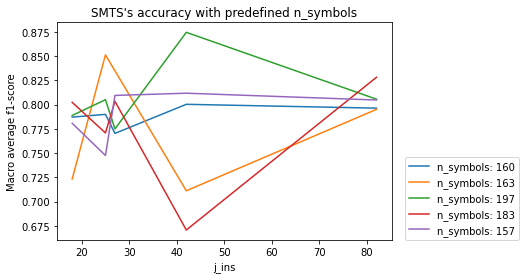

In [26]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


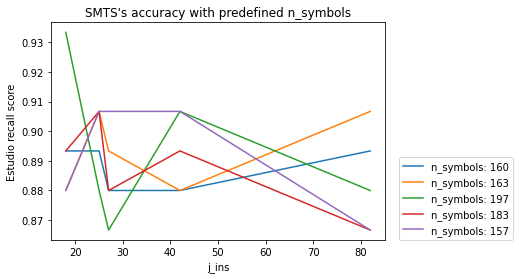

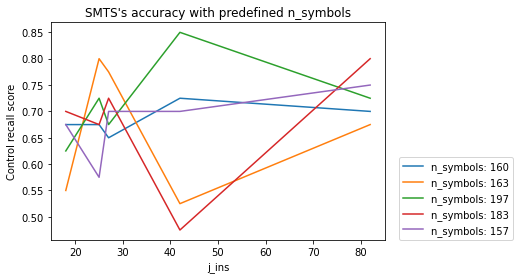

In [27]:
estudio_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['Estudio']['recall'][0],
                   'std': all_reports[z]['Estudio']['recall'][1]}),
    all_reports
))

control_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['Control']['recall'][0],
                   'std': all_reports[z]['Control']['recall'][1]}),
    all_reports
))

plot_score(
    [estudio_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Estudio recall score'
)

plot_score(
    [control_recall_scores],
    ('j_ins', 'n_symbols'),
    'SMTS',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Control recall score'
)


# <font color=#cd0000> Conclusiones </font>
- TODO - Unas breves conclusiones sobre los resultados obtenidos (influencia de la codificación, ...)